# Springboard Capstone Project 1 Final Submission - Edits

I made additional edits to my capstone 1 project submission. I did not predict on the younger players who have not yet been in the NBA for 5 years but I have included it here. I have also included a support vector machine approach.

In [1]:
# import all necessary libraries

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

import seaborn as sns
sns.set()

In [2]:
# import data and create separate dataframes

nba_rookie_data = pd.read_csv("C:/Users/jho/Desktop/data_science/nba_rookie_data.csv")
nba_rookie_data = nba_rookie_data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
## drop the name or not?
#nba_rookie_data = nba_rookie_data.drop(['Name'], axis=1)

# players who have played for at least 5 years
players_yes = nba_rookie_data[nba_rookie_data['TARGET_5Yrs'] == 1]

# players who have not played for at least 5 years
players_no = nba_rookie_data[nba_rookie_data['TARGET_5Yrs'] == 0]
players_no = players_no[players_no['Year Drafted'] <= 2012]

# young players who have not yet been in the league for five years
players_new = nba_rookie_data[nba_rookie_data['Year Drafted'] > 2012].drop('Year Drafted', axis=1)

# set of players who were drafted at least 5 years ago
players_old = nba_rookie_data[nba_rookie_data['Year Drafted'] <= 2012].drop('Year Drafted', axis=1)
#players_old.info()

In [3]:
# create columns for training the model

cols = ['GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'EFF']
X = players_old.reindex(columns=cols)
y = players_old.reindex(columns=['TARGET_5Yrs']).astype(int)

In [4]:
# for all players where it has been at least five years from their rookie season. 

# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values)

# create the logreg classifier
logreg = LogisticRegression()

# fit the classifier to the training data
logreg.fit(X_train, y_train)

# predict the labels of the test set
y_pred = logreg.predict(X_test)

# confusion matrix, classification report, and accuracy score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_pred, y_test))

[[ 45  62]
 [ 28 173]]
             precision    recall  f1-score   support

          0       0.62      0.42      0.50       107
          1       0.74      0.86      0.79       201

avg / total       0.69      0.71      0.69       308

0.707792207792


C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Prediction accuracy for logistic regression on the testing set this run is 70.78%, similar to the score I got previously.

In [5]:
# predict the label for the younger players (< 5 years).

# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0)

# create the logreg classifier
logreg = LogisticRegression()

# fit the classifier to the training data
logreg.fit(X_train, y_train)

# predict the labels of the test set
y_pred = logreg.predict(players_new[cols])

# confusion matrix, classification report, and accuracy score
print(confusion_matrix(players_new['TARGET_5Yrs'], y_pred))
print(classification_report(players_new['TARGET_5Yrs'], y_pred))
print(accuracy_score(y_pred, players_new['TARGET_5Yrs']))

[[30 68]
 [ 0  0]]
             precision    recall  f1-score   support

          0       1.00      0.31      0.47        98
          1       0.00      0.00      0.00         0

avg / total       1.00      0.31      0.47        98

0.30612244898


C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


A confusion matrix is generated as:

True Negative  |  False Positive
             _ _ _
False Negative |  True Positive

Since all of the younger players whose rookie season was less than 5 years ago, their classified labels are 0. I used train_test_split to create training and testing data sets on the older players. Since the testing dataset is the younger rookie players, I set the test_size to 0 and substituted players_new as the y_test. The true negatives were 30/98 and the false positives were 68/98. The false positives represent the younger players who were 'incorrectly classified' or predicted to have played in the NBA for 5 years. This ratio of predicting talented young players is about 69%, which is very close to the accuracy of the predictions on the older players!

Here is my KNN approach for older players.

C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  from ipykernel import kernelapp as app


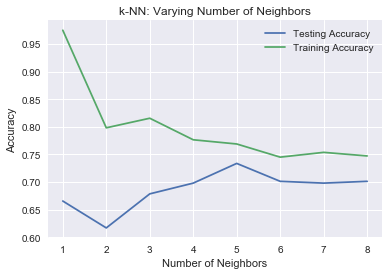

In [6]:
# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(players_old[cols].values, players_old[['TARGET_5Yrs']].values)

# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors = k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [7]:
# Create a k-NN classifier with 5 neighbors: knn
knn = KNeighborsClassifier(n_neighbors = 5)

# Fit the classifier to the training data
knn.fit(X_train, y_train)

# Print the accuracy
print(knn.score(X_test, y_test))

0.733766233766


C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """


k-value with the highest accuracy on the testing data is 5. The prediction accuracy for KNN in 73.38%, slightly higher than logistic regression.

Next I will compare KNN to Support Vector Machine.

In [8]:
# columns for training the SVM model

stats = players_old[['GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'EFF']].as_matrix()
player_label = np.where(players_old['TARGET_5Yrs'] == 1, 0,1)

In [9]:
# radial basis function kernel

model = svm.SVC(kernel='rbf', gamma='auto')
model.fit(stats, player_label)
prediction = model.predict(stats)
print(prediction)

[0 0 0 ..., 0 1 1]


In [10]:
print(confusion_matrix(player_label, prediction))
print(classification_report(player_label, prediction))
print(accuracy_score(prediction, player_label))

[[814   6]
 [ 51 359]]
             precision    recall  f1-score   support

          0       0.94      0.99      0.97       820
          1       0.98      0.88      0.93       410

avg / total       0.96      0.95      0.95      1230

0.953658536585


The RBF kernel returns the highest prediction accuracy of 95.37%. This kernel works best for nonlinear problems. 

In [11]:
# linear kernel

model = svm.SVC(kernel='linear')
model.fit(stats, player_label)
prediction = model.predict(stats)
print(prediction)

[0 0 0 ..., 1 1 1]


In [12]:
print(confusion_matrix(player_label, prediction))
print(classification_report(player_label, prediction))
print(accuracy_score(prediction, player_label))

[[722  98]
 [240 170]]
             precision    recall  f1-score   support

          0       0.75      0.88      0.81       820
          1       0.63      0.41      0.50       410

avg / total       0.71      0.73      0.71      1230

0.725203252033


The linear kernel performs about the same as the logistic regression model. Since both approaches are linear, the models are not optimal for the type of problem I have with multidimensional (likely nolinear) data.

In [13]:
# polynomial kernel. training the model took forever so i normalized the stats columns.

scaler = MinMaxScaler()
X = scaler.fit_transform(stats)

model_poly = svm.SVC(kernel='poly', degree=3)
model_poly.fit(X, player_label)
model_poly_prediction = model_poly.predict(X)

In [14]:
print(confusion_matrix(player_label, model_poly_prediction))
print(classification_report(player_label, model_poly_prediction))
print(accuracy_score(model_poly_prediction, player_label))

[[820   0]
 [410   0]]
             precision    recall  f1-score   support

          0       0.67      1.00      0.80       820
          1       0.00      0.00      0.00       410

avg / total       0.44      0.67      0.53      1230

0.666666666667


C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The poly kernel took forever to train, so I normalized the columns help the model perform better. This is the worst of the kernels, however.

Next I will apply the RBF kernel to see the predicted classifications for younger players.

In [15]:
# split data for training and testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0)

# create the logreg classifier
model = svm.SVC(kernel='linear')

# fit the classifier to the training data
model.fit(X_train, y_train)

# predict the labels of the test set
y_pred = model.predict(players_new[cols])

# confusion matrix, classification report, and accuracy score
print(confusion_matrix(players_new['TARGET_5Yrs'], y_pred))
print(classification_report(players_new['TARGET_5Yrs'], y_pred))
print(accuracy_score(y_pred, players_new['TARGET_5Yrs']))

[[ 0 98]
 [ 0  0]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        98
          1       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00        98

0.0


C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Based on the confusion matrix above, all of the young players are classified as playing in the NBA for at least five years with the RBF kernel SVM. Since 95% of the old players were classified correctly according to the model, 100% of the younger players will play for at least 5 years. This will be interesting to verify in 5 years. 